In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gc
import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
device = "cuda" if torch.cuda.is_available() else "cpu"

from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim

# Getting dataset ready

In [2]:
def get_npy_file_paths(directory):
    return sorted(glob.glob(os.path.join(directory, "*.npy")))

# load file paths 
lr_dir = "/kaggle/input/dataset-3a/Dataset/LR"  
hr_dir = "/kaggle/input/dataset-3a/Dataset/HR"
lr_path =  get_npy_file_paths(lr_dir)
hr_path = get_npy_file_paths(hr_dir)


In [3]:
lr_path_tr,lr_path_test = train_test_split(lr_path,train_size=0.9, shuffle=True,random_state=42)
hr_path_tr,hr_path_test = train_test_split(hr_path,train_size=0.9, shuffle=True,random_state=42)

In [4]:
# custom dataset class
class SRDataset(Dataset):
    def __init__(self, lr_path, hr_path, transform=None):
        self.lr_path = lr_path
        self.hr_path = hr_path
        self.transform = transform

    def __len__(self):
        return len(self.lr_path)

    def __getitem__(self, idx):
        lr = np.load(self.lr_path[idx]).astype(np.float32)  # Low-resolution image
        hr = np.load(self.hr_path[idx]).astype(np.float32)  # High-resolution image

        if self.transform:
            lr = self.transform(torch.tensor(lr, dtype=torch.float32))  
            hr = self.transform(torch.tensor(hr, dtype=torch.float32))
        return lr, hr

# Define transforms for normalization (-1 to 1 range)
transform = transforms.Compose([
    # transforms.Normalize(mean=[lr_mean], std=[lr_std])
])


In [5]:
# Loading  dataset

dataset_train = SRDataset(lr_path_tr, hr_path_tr, transform=transform)
dataset_test = SRDataset(lr_path_test,hr_path_test,transform=transform)
train_dataloader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset_test,batch_size=16,shuffle=True)

In [15]:
# RCAN Model
# Channel Attention (CA) Block
class CALayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(CALayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv_du = nn.Sequential(
            nn.Conv2d(channel, channel // reduction, 1, padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // reduction, channel, 1, padding=0, bias=True),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv_du(y)
        return x * y

# Residual Channel Attention Block (RCAB)
class RCAB(nn.Module):
    def __init__(self, channel):
        super(RCAB, self).__init__()
        self.conv1 = nn.Conv2d(channel, channel, 3, padding=1, bias=True)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channel, channel, 3, padding=1, bias=True)
        self.ca = CALayer(channel)
    
    def forward(self, x):
        res = self.conv1(x)
        res = self.relu(res)
        res = self.conv2(res)
        res = self.ca(res)
        return res + x  # Residual connection

# Residual Group (RG)
class ResidualGroup(nn.Module):
    def __init__(self, channel, num_rcab):
        super(ResidualGroup, self).__init__()
        self.rcabs = nn.Sequential(*[RCAB(channel) for _ in range(num_rcab)])
        self.conv = nn.Conv2d(channel, channel, 3, padding=1, bias=True)
    
    def forward(self, x):
        res = self.rcabs(x)
        res = self.conv(res)
        return res + x

# RCAN Model
class RCAN(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, num_features=64, num_rg=2, num_rcab=4):
        super(RCAN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, num_features, kernel_size=3, padding=1)
        
        self.residual_groups = nn.Sequential(*[ResidualGroup(num_features, num_rcab) for _ in range(num_rg)])
        self.conv2 = nn.Conv2d(num_features, num_features, kernel_size=3, padding=1)
        
        self.upsample = nn.Sequential(
            nn.Conv2d(num_features, num_features * 4, kernel_size=3, padding=1),
            nn.PixelShuffle(2),
            nn.Conv2d(num_features, out_channels, kernel_size=3, padding=1)
        )
    
    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.residual_groups(x1)
        x3 = self.conv2(x2) + x1  # Global residual connection
        out = self.upsample(x3)
        return torch.clamp(out, 0, 1)


In [63]:
import torch
import numpy as np
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(492)

In [64]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')  # Or use 'leaky_relu'
        if m.bias is not None:
            nn.init.zeros_(m.bias)

rcan.apply(init_weights)  # Apply once before training


RCAN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (residual_groups): Sequential(
    (0): ResidualGroup(
      (rcabs): Sequential(
        (0): RCAB(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (ca): CALayer(
            (avg_pool): AdaptiveAvgPool2d(output_size=1)
            (conv_du): Sequential(
              (0): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
              (1): ReLU(inplace=True)
              (2): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1))
              (3): Sigmoid()
            )
          )
        )
        (1): RCAB(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (ca): CALayer(
 

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Initialize model
rcan = RCAN().to(device)  

# Define loss function
criterion_pixel = nn.MSELoss()

# Define optimizer
optimizer = optim.Adam(rcan.parameters(), lr=3e-4)

# Define scheduler (Choose one)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)

num_epochs = 10  

for epoch in range(num_epochs):
    # Training Phase
    rcan.train()
    train_loss = 0.0
    for lr, hr in tqdm(train_dataloader):
        lr, hr = lr.to(device), hr.to(device)

        # Forward pass
        fake_hr = rcan(lr)
        
        # Compute loss
        loss = criterion_pixel(fake_hr, hr)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Evaluation Phase
    rcan.eval()
    test_loss = 0.0
    with torch.no_grad():
        for lr, hr in test_dataloader:
            lr, hr = lr.to(device), hr.to(device)
            fake_hr = rcan(lr)
            loss = criterion_pixel(fake_hr, hr)
            test_loss += loss.item()

    test_loss /= len(test_dataloader)

    # Update scheduler
    scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Curr Learning rate : {current_lr:.6f}")
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_dataloader):.6f}, Test Loss: {test_loss:.4f}")


100%|██████████| 282/282 [00:53<00:00,  5.28it/s]


Curr Learning rate : 0.000293
Epoch 1/10, Train Loss: 0.0005, Test Loss: 0.0001


100%|██████████| 282/282 [00:53<00:00,  5.25it/s]


Curr Learning rate : 0.000272
Epoch 2/10, Train Loss: 0.0001, Test Loss: 0.0001


100%|██████████| 282/282 [00:53<00:00,  5.26it/s]


Curr Learning rate : 0.000240
Epoch 3/10, Train Loss: 0.0001, Test Loss: 0.0001


100%|██████████| 282/282 [00:54<00:00,  5.17it/s]


Curr Learning rate : 0.000200
Epoch 4/10, Train Loss: 0.0001, Test Loss: 0.0001


100%|██████████| 282/282 [00:54<00:00,  5.20it/s]


Curr Learning rate : 0.000155
Epoch 5/10, Train Loss: 0.0001, Test Loss: 0.0001


100%|██████████| 282/282 [00:55<00:00,  5.13it/s]


Curr Learning rate : 0.000110
Epoch 6/10, Train Loss: 0.0001, Test Loss: 0.0001


100%|██████████| 282/282 [00:54<00:00,  5.17it/s]


Curr Learning rate : 0.000070
Epoch 7/10, Train Loss: 0.0001, Test Loss: 0.0001


100%|██████████| 282/282 [00:55<00:00,  5.09it/s]


Curr Learning rate : 0.000038
Epoch 8/10, Train Loss: 0.0001, Test Loss: 0.0001


100%|██████████| 282/282 [00:55<00:00,  5.05it/s]


Curr Learning rate : 0.000017
Epoch 9/10, Train Loss: 0.0001, Test Loss: 0.0001


100%|██████████| 282/282 [00:57<00:00,  4.89it/s]


Curr Learning rate : 0.000010
Epoch 10/10, Train Loss: 0.0001, Test Loss: 0.0001


In [ ]:
# save model
rcan.eval()
checkpoint = '/kaggle/working/RCAN_weights.pth'
torch.save(rcan.state_dict(),checkpoint)

In [ ]:
# Load the pretained model
rcan = RCAN().to(device)
rcan.load_state_dict(torch.load(checkpoint,map_location=device))

In [73]:
#  code for evaluating metric
# MSE loss
def mse(hr, sr):
    return np.mean((hr - sr) ** 2)
# PSNR 
def psnr(hr, sr):
    mse_value = mse(hr, sr)
    if mse_value == 0:
        return float('inf')  # No difference between images
    max_pixel = 1.0  # Assuming 8-bit images
    return 20 * np.log10(max_pixel / np.sqrt(mse_value))
# SSIM
def calculate_ssim(hr, sr):
    return ssim(hr, sr, data_range=hr.max() - hr.min())


In [74]:
def eval_metric(model,dataset):
    model.eval()
    model.to(device)

    avg_mse = 0.0
    avg_psnr = 0.0
    avg_ssim = 0.0

    for idx in tqdm(range(len(dataset))):
        hr_img = dataset[idx][1].to(device).squeeze()  # Move HR image to device
        lr_img = dataset[idx][0].unsqueeze(0).to(device)  # Move LR image to device

        with torch.no_grad():
            fake_hr_img = model(lr_img).squeeze().cpu().numpy()  # Move output to CPU for numpy

        avg_mse += mse(hr_img.cpu().numpy(), fake_hr_img)
        avg_psnr += psnr(hr_img.cpu().numpy(), fake_hr_img)
        avg_ssim += calculate_ssim(hr_img.cpu().numpy(), fake_hr_img)

    print(f'Average MSE Loss : {avg_mse / len(dataset):.4f}')
    print(f'Average PSNR : {avg_psnr / len(dataset):.4f}')
    print(f'Average SSIM : {avg_ssim / len(dataset):.4f}')
eval_metric(rcan,dataset_test)

100%|██████████| 1000/1000 [00:09<00:00, 101.31it/s]

Average MSE Loss : 0.0001
Average PSNR : 42.1707
Average SSIM : 0.9766


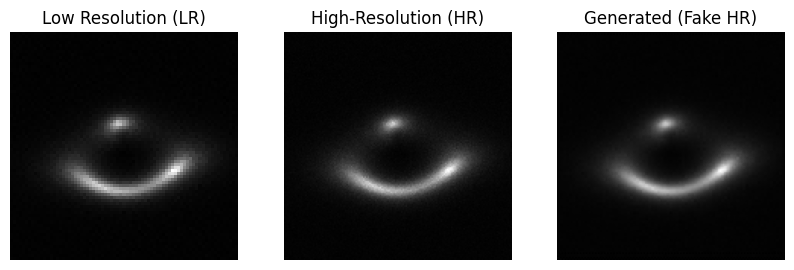

MSE Loss : 6.575940642505884e-05 || PSNR : 41.82042101108215 || SSIM : 0.9735062836215223


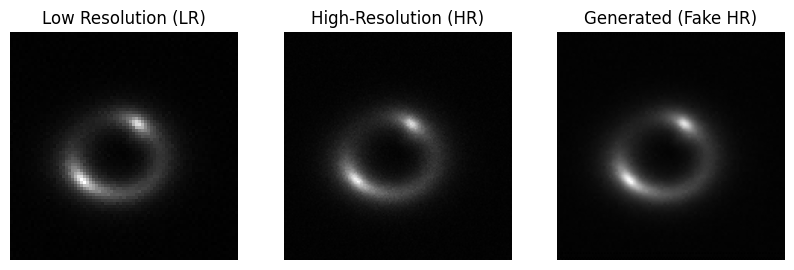

MSE Loss : 5.301092824083753e-05 || PSNR : 42.75634572366534 || SSIM : 0.9737712130939336


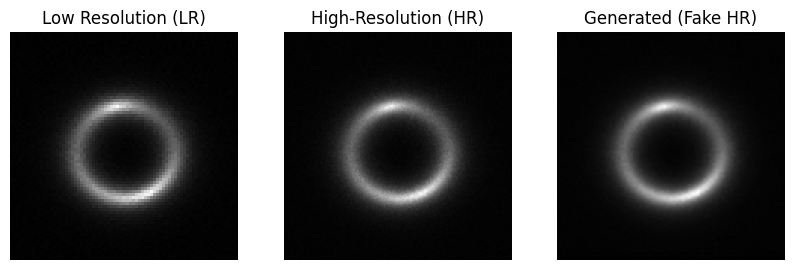

MSE Loss : 7.69501639297232e-05 || PSNR : 41.137904226941444 || SSIM : 0.9756539335048953


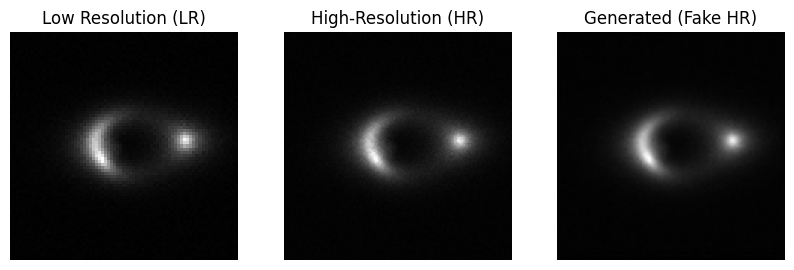

MSE Loss : 5.273984425002709e-05 || PSNR : 42.77861180806169 || SSIM : 0.9754400955179683


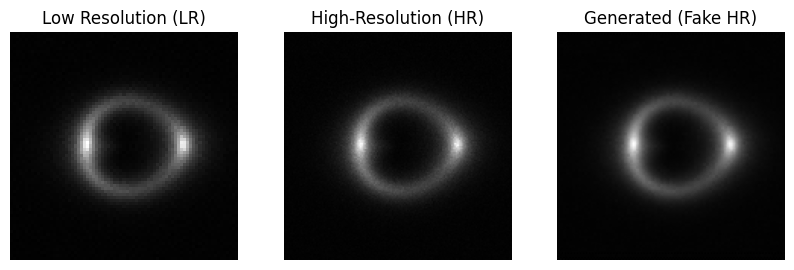

MSE Loss : 5.960035923635587e-05 || PSNR : 42.2475113631062 || SSIM : 0.9774018765289199


In [75]:
def visualize(model,idx,dataset_test):
    model.to(device)
    hr_img = dataset_test[idx][1].to(device).squeeze()  # Move HR image to device
    lr_img = dataset_test[idx][0].unsqueeze(0).to(device)  # Move LR image to device

    with torch.no_grad():
        fake_hr_img = model(lr_img).squeeze().cpu().numpy()  # Move output to CPU for numpy
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    # plot LR Image
    axes[0].imshow(lr_img.squeeze().cpu().numpy(), cmap='gray')  # Use cmap='gray' for grayscale images
    axes[0].set_title("Low Resolution (LR)")
    axes[0].axis("off")
    
    # Plot HR image
    axes[1].imshow(hr_img.squeeze().cpu().numpy(), cmap='gray')  # Use cmap='gray' for grayscale images
    axes[1].set_title("High-Resolution (HR)")
    axes[1].axis("off")
    
    # Plot Fake HR image
    axes[2].imshow(fake_hr_img.squeeze(), cmap='gray')
    axes[2].set_title("Generated (Fake HR)")
    axes[2].axis("off")
    
    # Show the images
    plt.show()
    print(f'MSE Loss : {mse(hr_img.cpu().numpy(),fake_hr_img)}',end=' || ')
    print(f'PSNR : {psnr(hr_img.cpu().numpy(),fake_hr_img)}',end=' || ')
    print(f'SSIM : {calculate_ssim(hr_img.cpu().numpy(),fake_hr_img)}')


samples = np.random.randint(0,len(dataset_test)-1,5)
for idx in samples:
    visualize(rcan,idx,dataset_test)